In [1]:
# for read / write wav files
import librosa
# for numerical matrix computation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# some math functions
import math
# fft and inverse fft algorithms
from scipy.fftpack import fft, ifft
# window function for smooth dft
from scipy.signal.windows import hann, blackman, blackmanharris, triang
# audio playback in IPython Notebook
from IPython.display import Audio

In [2]:
def dft(x):
    '''manual (naive) implementation of the DFT'''
    N = len(x)
    kv = np.arange(-N/2, N/2)
    nv = np.arange(-N/2, N/2)
    X = np.array([ np.dot(x, np.exp(-1j * 2 * np.pi * k * nv / N))  for k in kv])
    return X

def idft(X):
    '''manual (naive) implementation of the inverse DFT'''
    N = len(X)
    kv = np.arange(-N/2, N/2)
    nv = np.arange(-N/2, N/2)
    x = np.array([ np.dot(X, np.exp(1j * 2 * np.pi * n * kv / N)) for n in nv]) / N
    return x

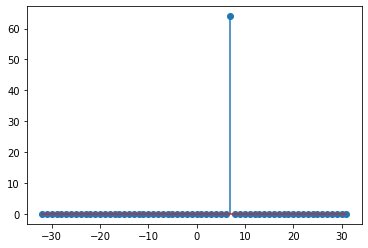

In [3]:
# DFT of a complex sinusoid
N = 64
k0 = 7
nv = np.arange(N)
kv = np.arange(-N/2, N/2)
x = np.exp(1j * 2 * np.pi * k0 * nv / N)
X = dft(x)
plt.stem(kv, np.abs(X), use_line_collection=True)
plt.show()

Look at the DFT above, it shows a peak at $x=7$, indicating the only frequency of the input signal

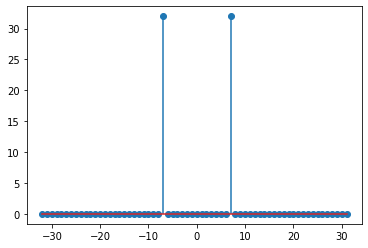

In [4]:
# DFT of a complex sinusoid (sum of two conjugate complex sinusoids)
# the DFT should have two peaks
N = 64
k0 = 7
nv = np.arange(N)
kv = np.arange(-N/2, N/2)
x = np.cos(2 * np.pi * k0 * nv / N)
X = dft(x)
plt.stem(kv, np.abs(X), use_line_collection=True)
plt.show()

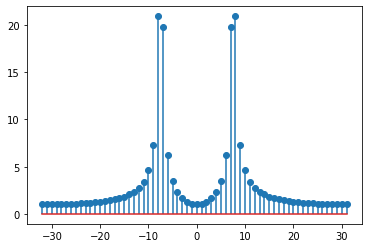

In [5]:
# The case where the frequency of the input signal is not an integer
N = 64
k0 = 7.5
nv = np.arange(N)
kv = np.arange(-N/2, N/2)
x = np.cos(2 * np.pi * k0 * nv / N)
X = dft(x)
plt.stem(kv, np.abs(X), use_line_collection=True)
plt.show()

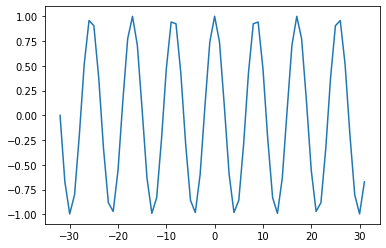

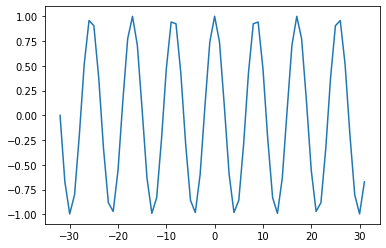

In [6]:
# comparing the input signal and the reconstructed signal using inverse DFT
N = 64
k0 = 7.5
nv = np.arange(-N/2, N/2)
kv = np.arange(-N/2, N/2)
x = np.cos(2 * np.pi * k0 * nv / N)
X = dft(x)
y = idft(X)
plt.figure()
plt.plot(nv, x)
plt.figure()
plt.plot(nv, np.real(y))
plt.show()

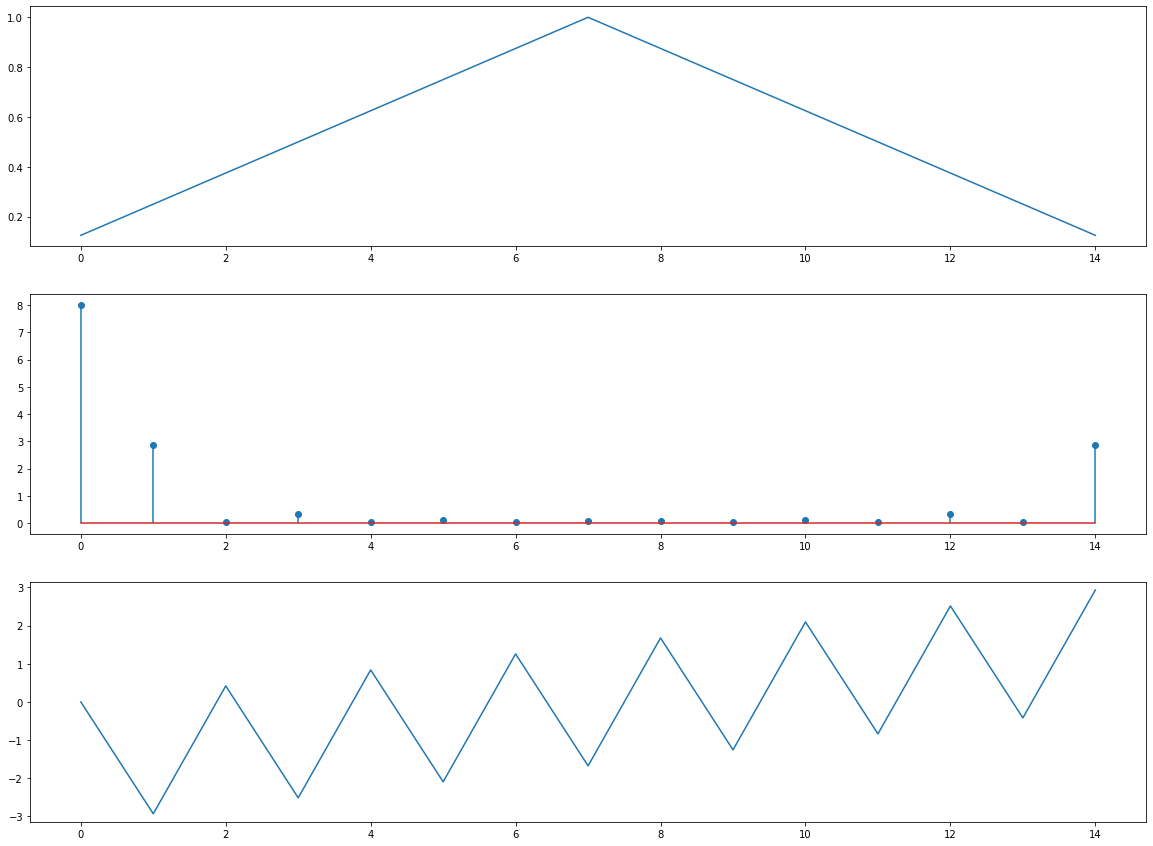

In [7]:
# the DFT of the triangle window
x = triang(15)
X = fft(x)
mX = np.abs(X)
pX = np.angle(X)
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(x)
plt.subplot(312)
plt.stem(mX, use_line_collection=True)
plt.subplot(313)
plt.plot(pX)
plt.ylim([-np.pi, np.pi])
plt.show()

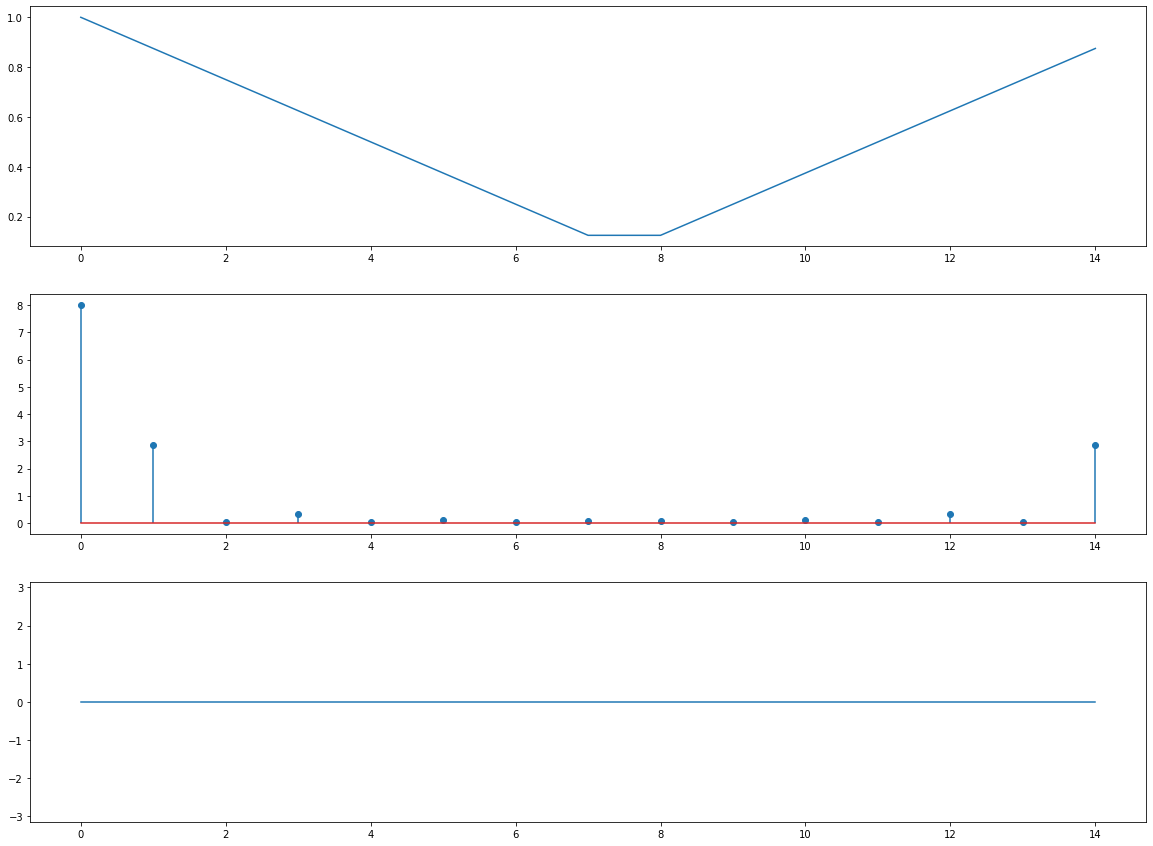

In [8]:
# zero phase DFT
x = triang(15)
fftbuffer = np.zeros_like(x)
fftbuffer[:8] = x[-8:]
fftbuffer[8:] = x[:-8]
X = fft(fftbuffer)
mX = np.abs(X)
pX = np.angle(X)
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(fftbuffer)
plt.subplot(312)
plt.stem(mX, use_line_collection=True)
plt.subplot(313)
plt.plot(pX)
plt.ylim([-np.pi, np.pi])
plt.show()

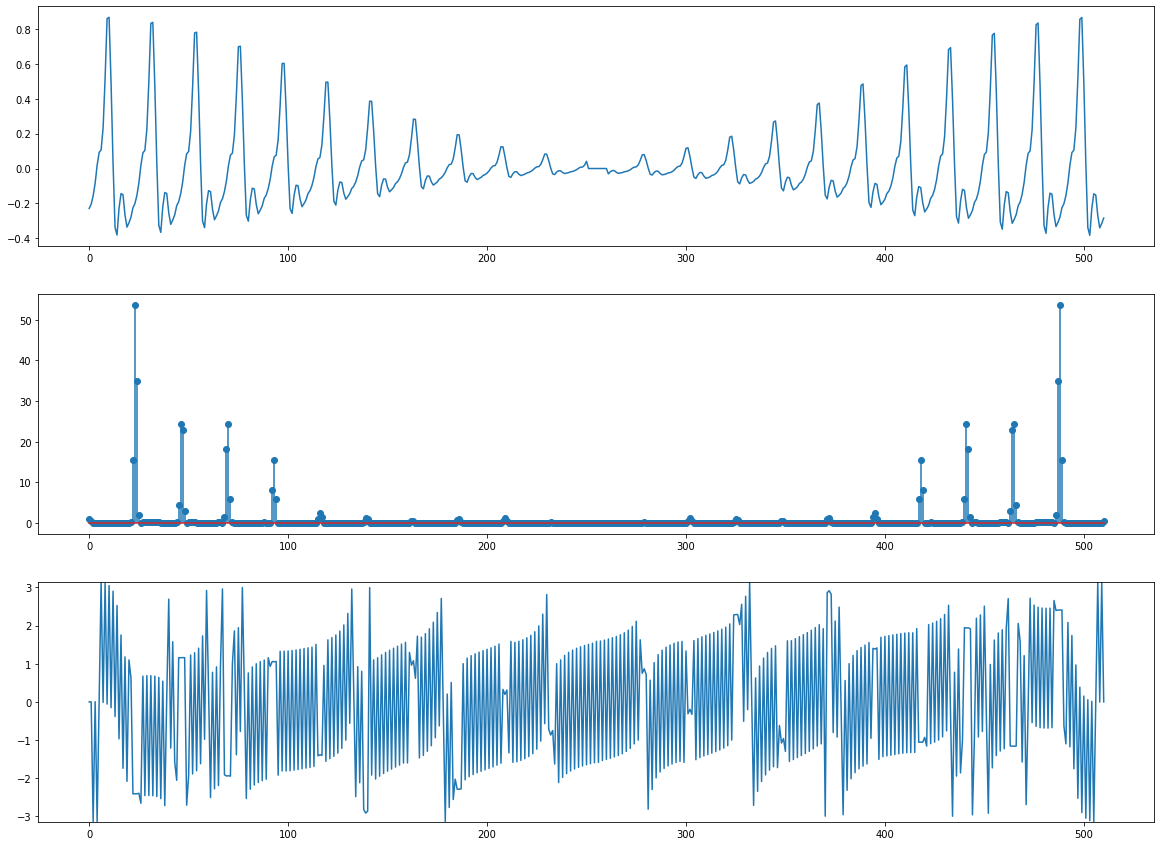

In [9]:
y, sr = librosa.load('soprano-E4.wav')
M = 501
x1 = y[5000:5000+M] * np.hamming(M)

N = 511
fftbuffer = np.zeros(N)
hM1 = int(math.floor((M+1)/2))
hM2 = int(math.floor(M/2))
fftbuffer[:hM1] = x1[hM2:]
fftbuffer[N-hM2:] = x1[:hM2]

X = fft(fftbuffer)
mX = np.abs(X)
pX = np.angle(X)

plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(fftbuffer)
plt.subplot(312)
plt.stem(mX, use_line_collection=True)
plt.subplot(313)
plt.plot(pX)
plt.ylim([-np.pi, np.pi])
plt.show()

In [10]:
def centered_padded_fft(x1, N, window):
    M = len(x1)
    hN = N//2
    
    x1 = x1 * window / np.sum(window)
    
    fftbuffer = np.zeros(N)
    hM1 = int(math.floor((M+1)/2))
    hM2 = int(math.floor(M/2))
    fftbuffer[:hM1] = x1[hM2:]
    fftbuffer[N-hM2:] = x1[:hM2]

    X = fft(fftbuffer)
    mX = 20*np.log10(np.abs(X[:hN]))
    pX = np.unwrap(np.angle(X[:hN]))
    return mX, pX

def centered_padded_ifft(mX, pX, M):
    N = len(mX)*2
    
    Y = np.zeros(N, dtype=np.complex)
    hN = N//2
    Y[:hN] = 10**(mX/20) * np.exp(1j*pX)
    Y[hN+1:] = 10**(mX[:0:-1]/20) * np.exp(-1j*pX[:0:-1])
    fftbuffer = np.real(ifft(Y))
    
    y = np.zeros(M)
    hM1 = int(math.floor((M+1)/2))
    hM2 = int(math.floor(M/2))
    y[hM2:] = fftbuffer[:hM1]
    y[:hM2] = fftbuffer[N-hM2:]

    return y

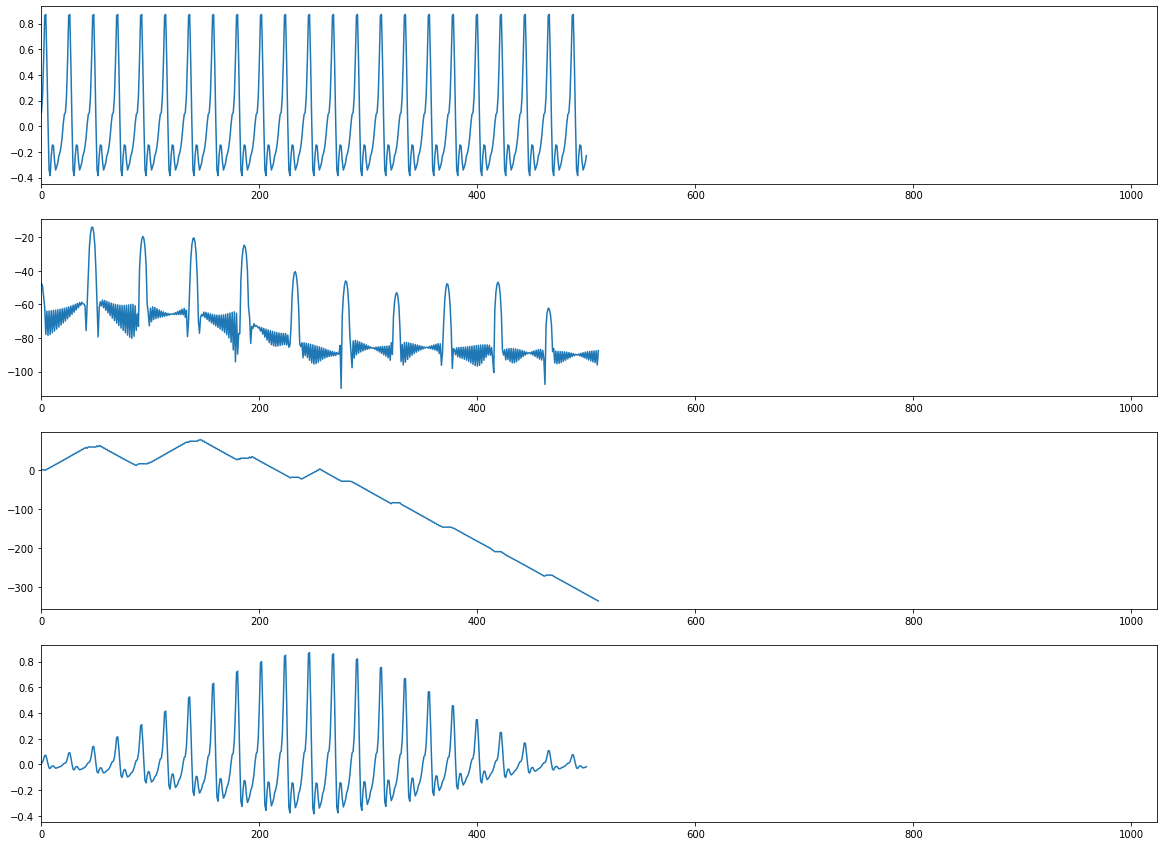

In [11]:
y, sr = librosa.load('soprano-E4.wav')
t = .4
M = 501
N = 1024
x1 = y[int(t*sr):int(t*sr)+M]

window = np.hamming(M)
mX, pX = centered_padded_fft(x1, N, window=window)
x2 = centered_padded_ifft(mX, pX, M)*sum(window)

plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(x1)
plt.xlim([0, N])
plt.subplot(412)
plt.plot(mX)
plt.xlim([0, N])
plt.subplot(413)
plt.plot(pX)
plt.xlim([0, N])
plt.subplot(414)
plt.plot(x2)
plt.xlim([0, N])
plt.show()
Audio(data=y, rate=sr)

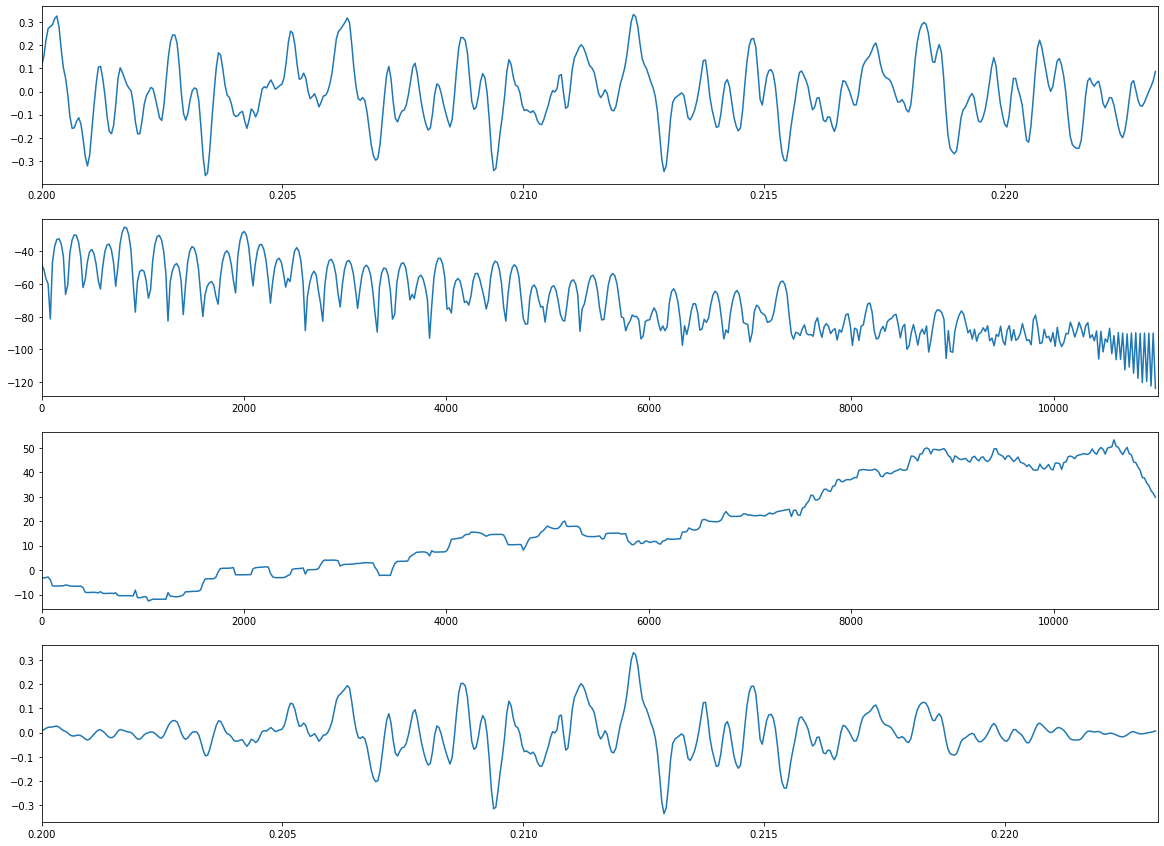

In [12]:
y, sr = librosa.load('piano.wav')
t = .2
M = 511
N = 1024
hN = N // 2
x1 = y[int(t*sr):int(t*sr)+M]

window = np.hamming(M)
mX, pX = centered_padded_fft(x1, N, window=window)
x2 = centered_padded_ifft(mX, pX, M)*sum(window)

plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(np.arange(M)/sr+t,x1)
plt.xlim([t, t+M/sr])
plt.subplot(412)
plt.plot(np.arange(hN)/(N)*(sr), mX)
plt.xlim([0, hN/N*sr])
plt.subplot(413)
plt.plot(np.arange(hN)/(N)*(sr), pX)
plt.xlim([0, hN/N*sr])
plt.subplot(414)
plt.plot(np.arange(M)/sr+t,x2)
plt.xlim([t, t+M/sr])
plt.show()

Audio(data=y, rate=sr)


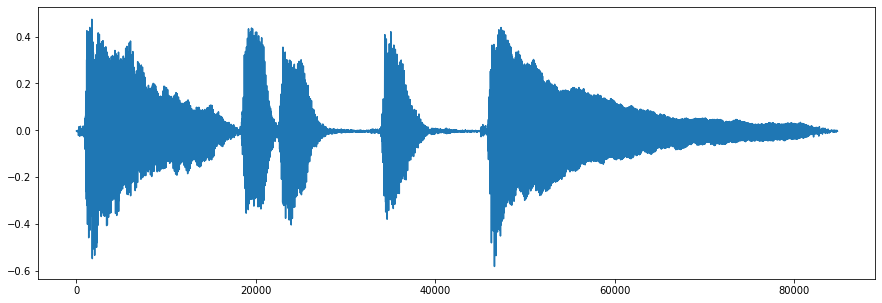

In [13]:
plt.figure(figsize=(15,5))
plt.plot(y)
plt.show()

In [14]:
def get_time_step(sampling_rate, duration):
    return np.arange(int(duration*sampling_rate)) / sampling_rate

def get_signal(t, func):
    return func(t)

sr = 10000 # sampling rate = 10Khz
duration = 0.5 # duration 20ms
f1, f2, f3 = 1000, 2000, 5000
figsize = (15, 3)

t = get_time_step(sr, duration)
signal_func = lambda x: 2*np.sin(2*np.pi*f1*x)+3*np.sin(2*np.pi*f2*x)+4*np.sin(2*np.pi*f3*x)
y = get_signal(t, signal_func)

Audio(y, rate=sr)

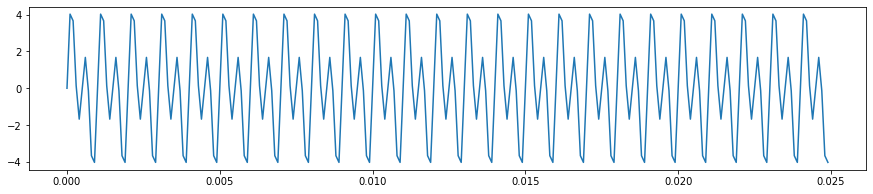

In [15]:
t = t[:int(0.025*sr)]
y = y[:int(0.025*sr)]
plt.figure(figsize=figsize)
plt.plot(t, y)
plt.show()

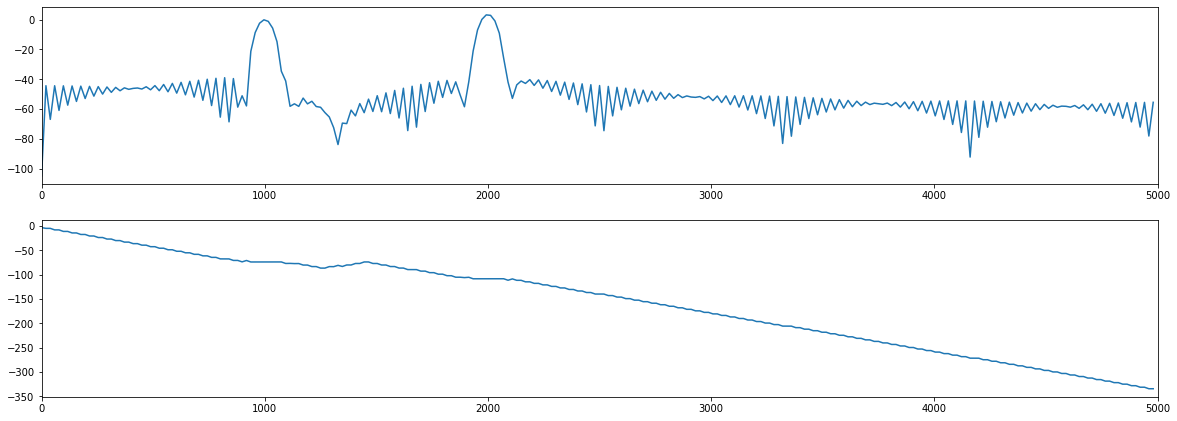

In [16]:
N = 512
hN = N // 2
mX, pX = centered_padded_fft(y, N, np.hamming(len(y)))
plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(np.arange(hN)/N*sr, mX)
plt.xlim([0, hN/N*sr])
plt.subplot(412)
plt.plot(np.arange(hN)/N*sr, pX)
plt.xlim([0, hN/N*sr])
plt.show()

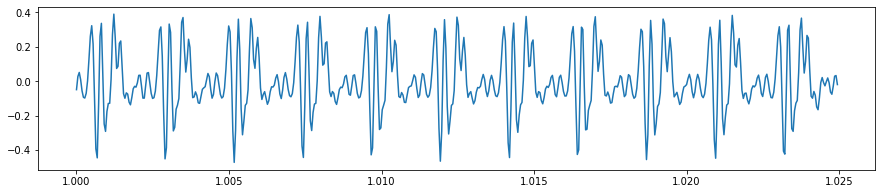

M 551


In [17]:
oboe, sr = librosa.load('oboe-A4.wav')
duration = 0.025
tmin = 1
tmax = tmin+duration
imin, imax = int(tmin*sr), int(tmax*sr)
t = np.arange(imin, imax)/sr
y = oboe[imin:imax]

figsize = (15, 3)
plt.figure(figsize=figsize)
plt.plot(t, y)
plt.show()
print("M", len(y))
Audio(data=y, rate=sr)

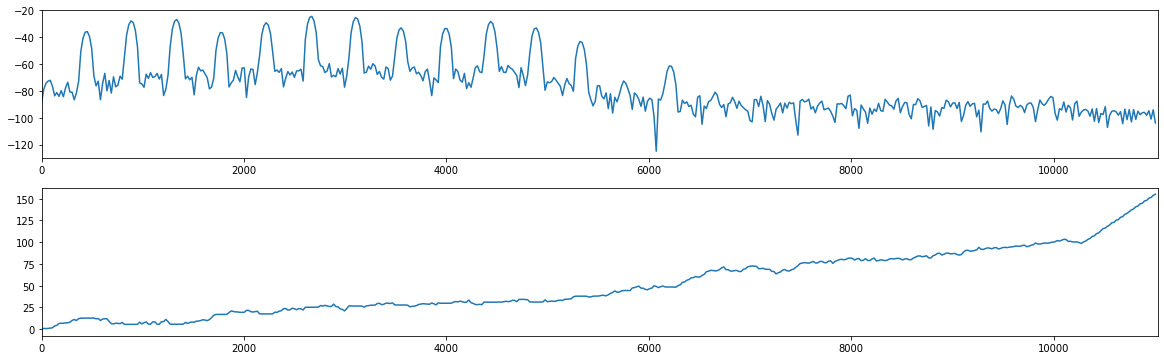

In [18]:
N = 1024
hN = N // 2
mX, pX = centered_padded_fft(y, N, np.hamming(len(y)))
plt.figure(figsize=(20,6))
plt.subplot(211)
plt.plot(np.arange(hN)/N*sr, mX)
plt.xlim([0, hN/N*sr])
plt.subplot(212)
plt.plot(np.arange(hN)/N*sr, pX)
plt.xlim([0, hN/N*sr])
plt.show()

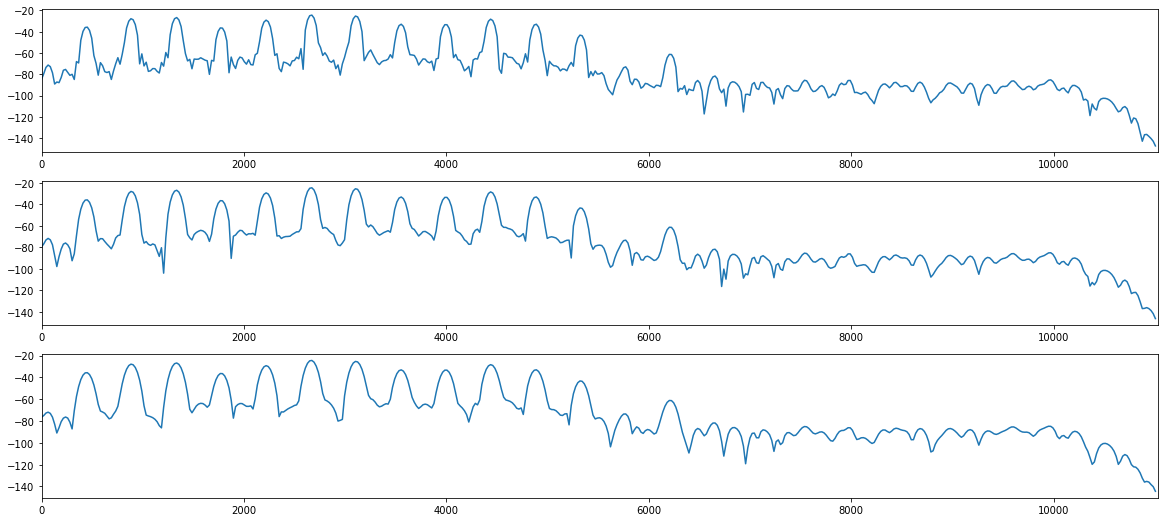

In [19]:
N = 1024
hN = N // 2
mX_hann, _ = centered_padded_fft(y, N, hann(len(y)))
mX_blackman, _ = centered_padded_fft(y, N, blackman(len(y)))
mX_blackman_harris, _ = centered_padded_fft(y, N, blackmanharris(len(y)))
plt.figure(figsize=(20,9))
plt.subplot(311)
plt.plot(np.arange(hN)/N*sr, mX_hann)
plt.xlim([0, hN/N*sr])
plt.subplot(312)
plt.plot(np.arange(hN)/N*sr, mX_blackman)
plt.xlim([0, hN/N*sr])
plt.subplot(313)
plt.plot(np.arange(hN)/N*sr, mX_blackman_harris)
plt.xlim([0, hN/N*sr])
plt.show()